In [1]:
#Load packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from xgboost import XGBClassifier
pd.set_option('display.max_columns', None)

# 1: Load Datasets

In [2]:
data=pd.read_excel('./int303-big-data-analysis/startup_train.xlsx')
test_xlsx=pd.read_excel('./int303-big-data-analysis/startup_test_new.xlsx')
# Convert closed to 0 and acquired to 1
data['status'] = data.status.map({'acquired':1, 'closed':0})
ID_list=test_xlsx['ID']

In [3]:
data.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,founded_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,state_code.1,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1/1/2007,4/1/2009,1/1/2010,2.2493,3.0027,4.6685,6.7041,3,3,375000,3,CA,1,0,0,0,0,music,0,0,0,0,0,0,0,0,0,1,c:6669,0,1,0,0,0,0,1.0000,0,1
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1/1/2000,2/14/2005,12/28/2009,5.1260,9.9973,7.0055,7.0055,9,4,40100000,1,CA,1,0,0,0,0,enterprise,0,0,0,1,0,0,0,0,0,0,c:16283,1,0,0,1,1,1,4.7500,1,1
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,3/18/2009,3/30/2010,3/30/2010,1.0329,1.0329,1.4575,2.2055,5,1,2600000,2,CA,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,c:65620,0,0,1,0,0,0,4.0000,1,1
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1/1/2002,2/17/2005,4/25/2007,3.1315,5.3151,6.0027,6.0027,5,3,40000000,1,CA,1,0,0,0,0,software,1,0,0,0,0,0,0,0,0,0,c:42668,0,0,0,1,1,1,3.3333,1,1
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,8/1/2010,8/1/2010,4/1/2012,0.0000,1.6685,0.0384,0.0384,2,2,1300000,1,CA,1,0,0,0,0,games_video,0,0,0,0,0,1,0,0,0,0,c:65806,1,1,0,0,0,0,1.0000,1,0


# 2: Data Cleaning

## 2.1: Drop Dulicated Data and Useless attributes


In [4]:
data.duplicated().sum()

0

In [5]:
data.duplicated(subset=['name']).sum()

1

In [6]:
data=data.drop_duplicates(subset=['name'])
data.duplicated(subset=['name']).sum()

0

Some attributes such as 'id' are useless and some attribute such as 'state_code, category_code' has done one-hot encoding, so just delete them

In [7]:
data=data.drop(['Unnamed: 0','name','Unnamed: 6','zip_code',
                'latitude','longitude','id','state_code','state_code.1','category_code','founded_at',
                'first_funding_at', 'last_funding_at','object_id','city'],axis=1)

## 2.2: Fill Missing Data

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847 entries, 0 to 847
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age_first_funding_year    847 non-null    float64
 1   age_last_funding_year     847 non-null    float64
 2   age_first_milestone_year  701 non-null    float64
 3   age_last_milestone_year   701 non-null    float64
 4   relationships             847 non-null    int64  
 5   funding_rounds            847 non-null    int64  
 6   funding_total_usd         847 non-null    int64  
 7   milestones                847 non-null    int64  
 8   is_CA                     847 non-null    int64  
 9   is_NY                     847 non-null    int64  
 10  is_MA                     847 non-null    int64  
 11  is_TX                     847 non-null    int64  
 12  is_otherstate             847 non-null    int64  
 13  is_software               847 non-null    int64  
 14  is_web    

Some data('age_first_milestone_year','age_last_milestone_year' are missing, fill them 0

In [9]:
data['age_first_milestone_year'] = data['age_first_milestone_year'].fillna(0)
data['age_last_milestone_year'] = data['age_last_milestone_year'].fillna(0)

In [10]:
data.describe()

,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,is_MA,is_TX,is_otherstate,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
count,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,8.470000e+02,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000
mean,2.224909,3.894072,2.523192,3.936728,7.669421,2.296340,2.578625e+07,1.833530,0.523022,0.114522,0.089728,0.044864,0.226682,0.167651,0.160567,0.081464,0.083825,0.064935,0.055490,0.029516,0.036600,0.002361,0.317591,0.316411,0.262102,0.507674,0.388430,0.224321,0.097993,2.798011,0.802834,0.639906
std,2.524627,2.993050,2.946955,3.463959,7.307776,1.387473,1.978431e+08,1.339316,0.499765,0.318632,0.285961,0.207128,0.418933,0.373776,0.367348,0.273708,0.277289,0.246557,0.229069,0.169348,0.187888,0.048564,0.465815,0.465350,0.440037,0.500236,0.487681,0.417381,0.297481,1.855597,0.398094,0.480311
min,-9.046600,-9.046600,-14.169900,-3.882200,0.000000,1.000000,1.100000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.547950,1.641100,0.000000,0.846550,3.000000,1.000000,2.600000e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.366650,1.000000,0.000000
50%,1.452100,3.468500,2.000000,3.704100,5.000000,2.000000,1.000000e+07,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.333300,1.000000,1.000000
75%,3.520550,5.501350,4.002700,6.005500,10.000000,3.000000,2.425000e+07,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.666700,1.000000,1.000000
max,21.895900,21.895900,24.684900,24.684900,63.000000,10.000000,5.700000e+09,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,1.000000,1.000000


Observe the min row:'age_first_funding_year','age_last_funding_year','age_first_milestone_year','age_last_milestone_year' are less than 0, which is not possible, so we need to drop these rows.

In [11]:
data=data.drop(data[data.age_first_funding_year<0].index)
data=data.drop(data[data.age_last_funding_year<0].index)
data=data.drop(data[data.age_first_milestone_year<0].index)
data=data.drop(data[data.age_last_milestone_year<0].index)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 770 entries, 0 to 846
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age_first_funding_year    770 non-null    float64
 1   age_last_funding_year     770 non-null    float64
 2   age_first_milestone_year  770 non-null    float64
 3   age_last_milestone_year   770 non-null    float64
 4   relationships             770 non-null    int64  
 5   funding_rounds            770 non-null    int64  
 6   funding_total_usd         770 non-null    int64  
 7   milestones                770 non-null    int64  
 8   is_CA                     770 non-null    int64  
 9   is_NY                     770 non-null    int64  
 10  is_MA                     770 non-null    int64  
 11  is_TX                     770 non-null    int64  
 12  is_otherstate             770 non-null    int64  
 13  is_software               770 non-null    int64  
 14  is_web    

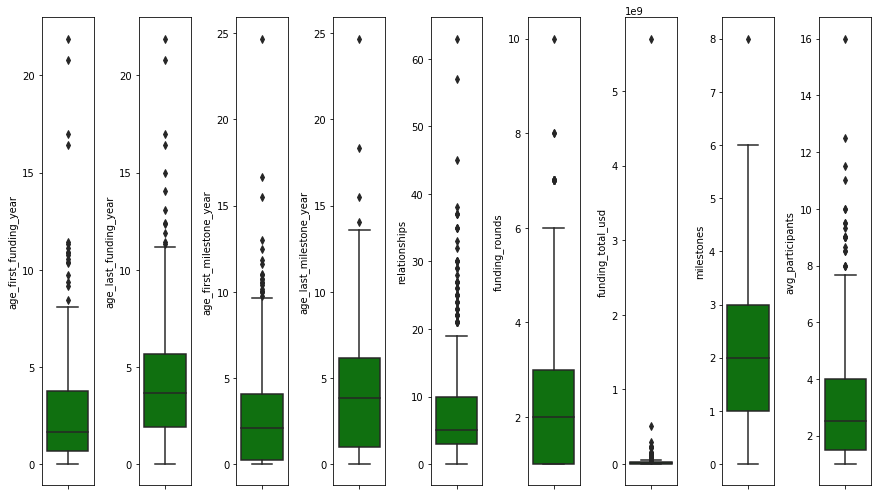

In [13]:
features = ['age_first_funding_year', 'age_last_funding_year','age_first_milestone_year', 
               'age_last_milestone_year', 'relationships','funding_rounds', 'funding_total_usd',
               'milestones','avg_participants']
plt.figure(figsize=(15, 7))
for i in range(0, len(features)):
    plt.subplot(1, 11, i+1)
    sns.boxplot(y=data[features[i]],color='green',orient='v')
    plt.tight_layout()

In [14]:
data[features].skew(axis=0, skipna=True)<2

age_first_funding_year      False
age_last_funding_year        True
age_first_milestone_year     True
age_last_milestone_year      True
relationships               False
funding_rounds               True
funding_total_usd           False
milestones                   True
avg_participants             True
dtype: bool

## Data Normalization

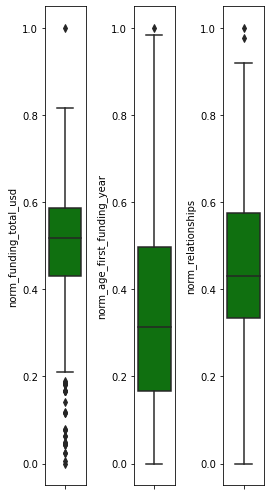

In [15]:
features=['funding_total_usd','age_first_funding_year','relationships']
from sklearn.preprocessing import MinMaxScaler, StandardScaler
for var in features :
    data['norm_'+var] =np.log1p(data[var])

features_2=['norm_funding_total_usd','norm_age_first_funding_year', 'norm_relationships']

for var in features_2 :
    data[var] = MinMaxScaler().fit_transform(data[var].values.reshape(len(data), 1))
    
plt.figure(figsize=(15, 7))
for i in range(0, len(features_2)):
    plt.subplot(1, 12, i+1)
    sns.boxplot(y=data[features_2[i]],color='green',orient='v')
    plt.tight_layout()

In [16]:
# do the same operation for testing data
# Drop duplicated data
test_xlsx=test_xlsx.drop_duplicates(subset=['name'])
# Remove useless attributes
test_xlsx=test_xlsx.drop(['Unnamed: 0','name','Unnamed: 6','zip_code',
                'latitude','longitude','id','state_code','state_code.1','category_code','founded_at',
                'first_funding_at', 'last_funding_at','object_id','city','ID','status'],axis=1)
# Fill null values
test_xlsx['age_first_milestone_year'] = test_xlsx['age_first_milestone_year'].fillna(0)
test_xlsx['age_last_milestone_year'] = test_xlsx['age_last_milestone_year'].fillna(0)

In [17]:
features=['funding_total_usd','age_first_funding_year','relationships']
from sklearn.preprocessing import MinMaxScaler, StandardScaler
for var in features :
    test_xlsx['norm_'+var] =np.log1p(test_xlsx[var])

features_2=['norm_funding_total_usd','norm_age_first_funding_year', 'norm_relationships']

for var in features_2 :
    test_xlsx[var] = MinMaxScaler().fit_transform(test_xlsx[var].values.reshape(len(test_xlsx), 1))
    

In [18]:
#split the dataset into train and test sets
train_data=data.loc[:,data.columns!='status']
train_target=data.loc[:,'status']
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target,test_size=0.1)

In [19]:
#Check Null Values
print(X_train.isnull().values.any())
print(y_train.isnull().values.any())

False
False


# Model Construction

In [20]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=8) # Hyperparameter that can be changed
#Train the model using the training sets
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
#Import scikit-learn metrics module for accuracy calculation

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5844155844155844


In [21]:
# GridSearchCV for RandomForestClassifier
rf = RandomForestClassifier(n_jobs = -1, random_state = 10)
params = {
    'n_estimators': np.linspace(5, 300, 30,dtype=int),
    'max_depth': np.linspace(2, 32, 8,dtype=int)
}

cv = GridSearchCV(rf, params, cv = 5, n_jobs = -1)
cv.fit(X_train, y_train)
pd.DataFrame(cv.cv_results_).sort_values('mean_test_score', ascending = False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
67,0.192532,0.004893,0.021566,0.005630,10,76,"{'max_depth': 10, 'n_estimators': 76}",0.812950,0.827338,0.769784,0.862319,0.818841,0.818246,0.029672,1
72,0.238820,0.048235,0.028585,0.007732,10,127,"{'max_depth': 10, 'n_estimators': 127}",0.812950,0.820144,0.776978,0.855072,0.818841,0.816797,0.024822,2
42,0.246096,0.023663,0.025979,0.008187,6,127,"{'max_depth': 6, 'n_estimators': 127}",0.798561,0.834532,0.784173,0.833333,0.833333,0.816787,0.021252,3
33,0.081452,0.020502,0.023122,0.005376,6,35,"{'max_depth': 6, 'n_estimators': 35}",0.820144,0.841727,0.776978,0.833333,0.811594,0.816755,0.022444,4
160,0.264329,0.017829,0.029403,0.006037,23,106,"{'max_depth': 23, 'n_estimators': 106}",0.798561,0.827338,0.784173,0.840580,0.826087,0.815348,0.020734,5


In [31]:
# Random Forest
# import class, instantiate estimator, fit with training set
forest = RandomForestClassifier(n_estimators=100, max_depth=4, criterion="gini")
forest.fit(X_train, y_train)
# make predictions
y_pred = forest.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7792207792207793
[21:33:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:19] WARNING: 

[21:33:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:20] WARNING: /Users/runner/miniforge3/cond

[21:33:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:21] WARNING: /Users/runner/miniforge3/cond

[21:33:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:17] WARNING: /Users/runner/miniforge3/cond

[21:33:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:33:17] WARNING: /Users/runner/miniforge3/cond

In [23]:
# GridSearchCV for Adaboost
ab = AdaBoostClassifier()
params = {
    'n_estimators': np.linspace(5, 300, 10,dtype=int),
    'learning_rate': np.linspace(0.05,0.5,5,dtype=float)
}
cv = GridSearchCV(ab, params, cv = 5, n_jobs = -1)
cv.fit(X_train, y_train)
pd.DataFrame(cv.cv_results_).sort_values('mean_test_score', ascending = False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,0.193891,0.005028,0.016122,0.002913,0.1625,103,"{'learning_rate': 0.1625, 'n_estimators': 103}",0.798561,0.798561,0.791367,0.818841,0.855072,0.812480,0.023185,1
9,0.596625,0.032471,0.042467,0.003451,0.05,300,"{'learning_rate': 0.05, 'n_estimators': 300}",0.798561,0.798561,0.776978,0.826087,0.855072,0.811052,0.026970,2
4,0.248585,0.006488,0.019021,0.000804,0.05,136,"{'learning_rate': 0.05, 'n_estimators': 136}",0.798561,0.798561,0.776978,0.818841,0.862319,0.811052,0.028851,2
5,0.314449,0.024710,0.026999,0.003829,0.05,168,"{'learning_rate': 0.05, 'n_estimators': 168}",0.791367,0.798561,0.784173,0.818841,0.862319,0.811052,0.028125,4
6,0.367465,0.018488,0.029104,0.002219,0.05,201,"{'learning_rate': 0.05, 'n_estimators': 201}",0.798561,0.798561,0.784173,0.818841,0.855072,0.811042,0.024629,5


In [24]:
ab = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
ab.fit(X_train, y_train)
y_pred = ab.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7792207792207793


In [25]:
# GridSearchCV for Xgboost
from sklearn.model_selection import GridSearchCV
xgc=XGBClassifier(use_label_encoder=False)
params = {
    'n_estimators': np.linspace(50, 300, 5,dtype=int),
    'learning_rate': np.linspace(0.1,0.5,5,dtype=float),
    'max_depth': [5, 10]
}
cv = GridSearchCV(xgc, params, cv = 5, n_jobs = -1)
cv.fit(X_train, y_train)
pd.DataFrame(cv.cv_results_).sort_values('mean_test_score', ascending = False).head()

[21:34:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.079565,0.027668,0.002646,0.000245,0.1,5,50,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.798561,0.791367,0.769784,0.811594,0.797101,0.793682,0.013659,1
6,3.428428,0.016567,0.003147,0.000713,0.1,10,112,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.791367,0.769784,0.776978,0.811594,0.797101,0.789365,0.014798,2
1,1.948744,0.122728,0.002569,0.000299,0.1,5,112,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.784173,0.769784,0.791367,0.804348,0.775362,0.785007,0.012165,3
5,1.818678,0.038925,0.002874,0.000586,0.1,10,50,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.776978,0.769784,0.769784,0.804348,0.797101,0.783599,0.014411,4
7,4.698098,0.115317,0.006432,0.005989,0.1,10,175,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.776978,0.762590,0.769784,0.797101,0.797101,0.780711,0.014135,5


In [26]:
# XGBoost
xgc=XGBClassifier(learning_rate=0.2,n_estimators=50, max_depth=5,
                  objective= 'binary:logistic',colsample_bytree = 0.8,subsample=0.8,use_label_encoder=False) 
xgc.fit(X_train, y_train)
y_pred=xgc.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

[21:34:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.7792207792207793


In [27]:
status_list=forest.predict(test_xlsx)
result=pd.DataFrame()
result['ID']=ID_list
result['status']=status_list
result['status'] = result.status.map({1:'acquired', 0:'closed'})
result.to_csv("randomforest.csv",index=False)

In [28]:
status_list=ab.predict(test_xlsx)
result=pd.DataFrame()
result['ID']=ID_list
result['status']=status_list
result['status'] = result.status.map({1:'acquired', 0:'closed'})
result.to_csv("adaboost.csv",index=False)

In [29]:
status_list=xgc.predict(test_xlsx)
result=pd.DataFrame()
result['ID']=ID_list
result['status']=status_list
result['status'] = result.status.map({1:'acquired', 0:'closed'})
result.to_csv("xgboost.csv",index=False)

# Model Testing